# Algorithms Performance Analysis

## Importing Libraries

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from DSSE import DroneSwarmSearch
import csv

## Importing Necessary Modules

In [10]:
from config import get_config
from test_policy import get_model, play_one_episode

## Load Data

In [11]:
DATA_FOLDER = "data"
def load_data(config, algorithm, path=None):
    file_path = f"{DATA_FOLDER}/statistics_{config}_{algorithm}.csv"
    if path:
        file_path = path
    statistics = pd.read_csv(file_path)
    return statistics

## Plotting Learning Curves

In [5]:
def plot_learning_curve(statistics, config, algorithm):
    num_drones = config.n_drones
    disperse_constant = config.disperse_constant
    plt.style.use("seaborn-v0_8-darkgrid")
    fig, ax1 = plt.subplots(figsize=(10, 6))
    ax2 = ax1.twinx()

    # Plot mean rewards considering a window of 500 episodes
    ax1.plot(
        statistics["episode"],
        statistics["rewards"].rolling(500).mean(),
        "r-",
        label="Mean Rewards",
    )
    ax1.set_ylabel("Mean Rewards")

    # Divide actions by the number of drones to get the mean number of actions per drone
    statistics["actions"] = statistics["actions"] / num_drones

    ax2.plot(
        statistics["episode"],
        statistics["actions"].rolling(500).mean(),
        "b-",
        label="Mean Actions",
    )
    ax2.set_ylabel("Mean Actions")

    # Legend, title and labels
    fig.legend()
    plt.title(f"Learning Curve - {algorithm} ({num_drones = }, {disperse_constant = })")
    ax1.set_xlabel("Episodes")
    plt.grid()
    algorithm_name = "_".join(algorithm.split(" ")).lower()
    plt.savefig(f"imgs/learning_curve_nd{num_drones}_dc{disperse_constant}_{algorithm_name}.png", dpi=300)
    plt.show()

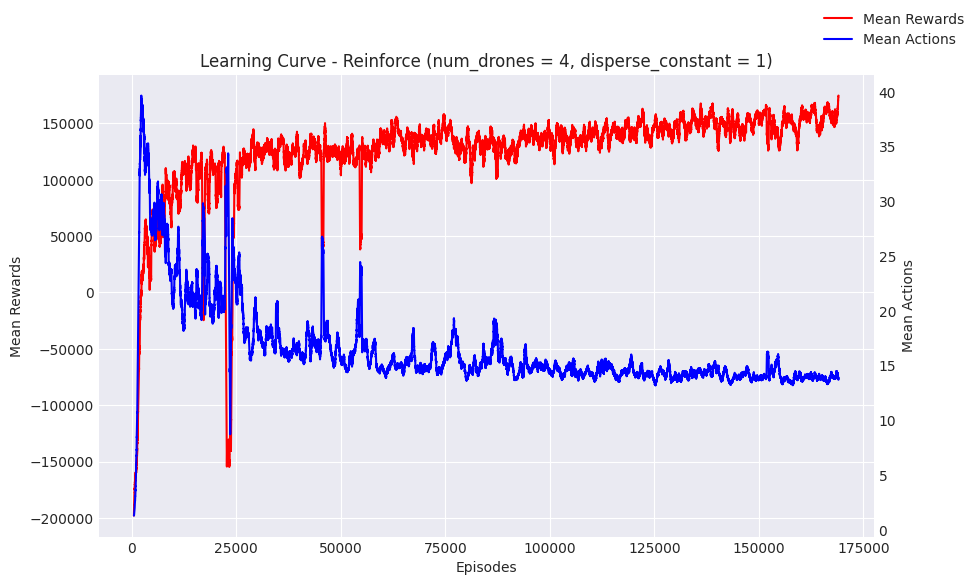

In [7]:
## Reinforce old
config_2 = get_config(2)
statistics_2 = load_data(config_2, "Reinforce", "data/statistics_20_4_1_new.csv")
plot_learning_curve(statistics_2, config_2, "Reinforce")

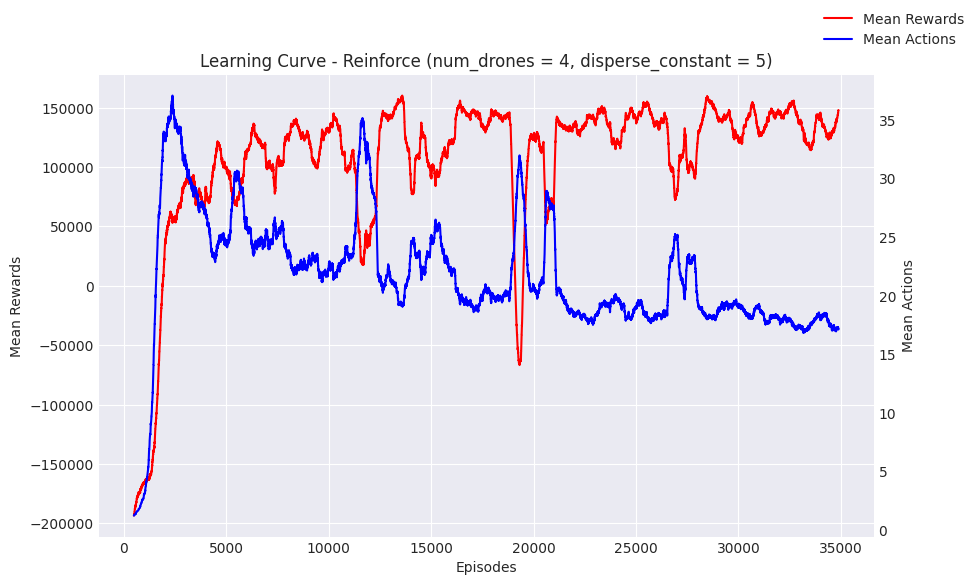

In [8]:
config_4 = get_config(4)
statistics_4 = load_data(config_4, "Reinforce", "data/statistics_20_4_5_new.csv")
plot_learning_curve(statistics_4, config_4, "Reinforce")

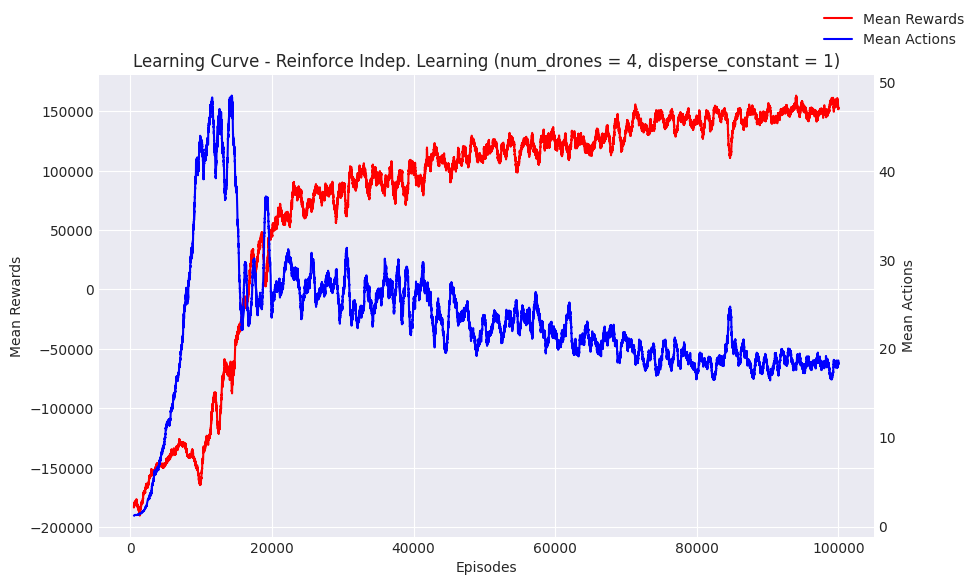

In [6]:
config_2 = get_config(2)
stat_rf_il = load_data(config_2, "reinforce_il")
plot_learning_curve(stat_rf_il, config_2, "Reinforce Indep. Learning")

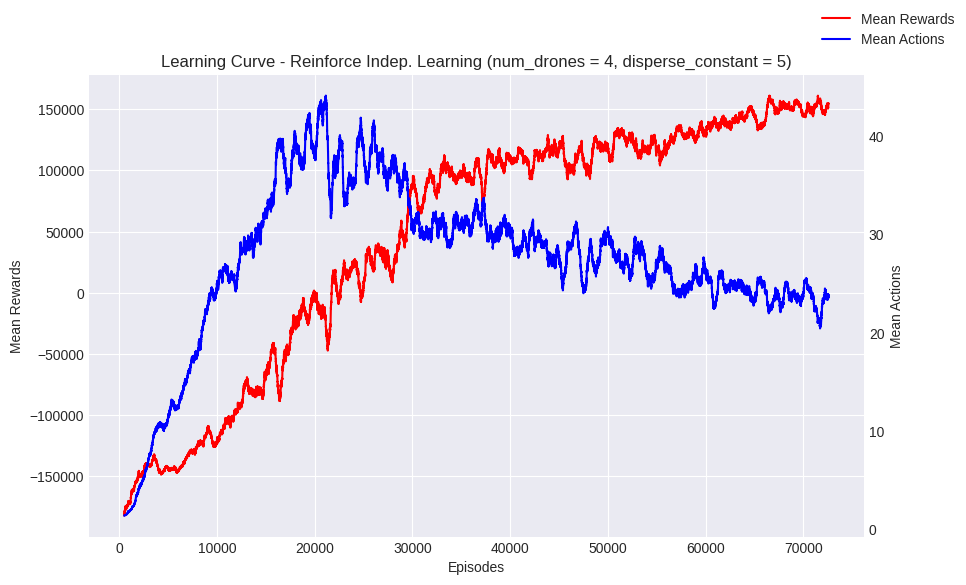

In [63]:
config_4 = get_config(4)
stat_rf_il = load_data(config_4, "reinforce_il")
plot_learning_curve(stat_rf_il, config_4, "Reinforce Indep. Learning")

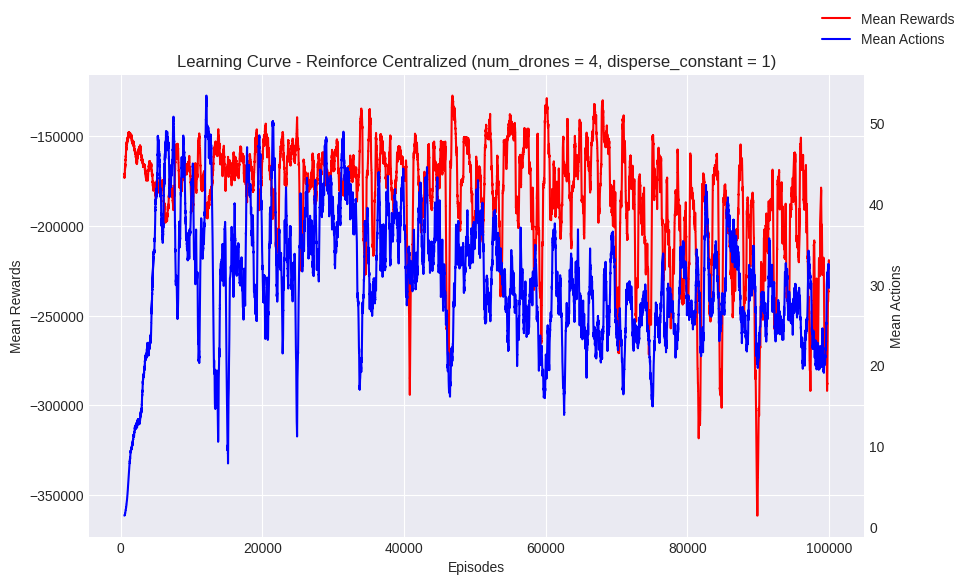

In [64]:
stat_rf = load_data(config_2, "reinforce")
plot_learning_curve(stat_rf, config_2, "Reinforce Centralized")

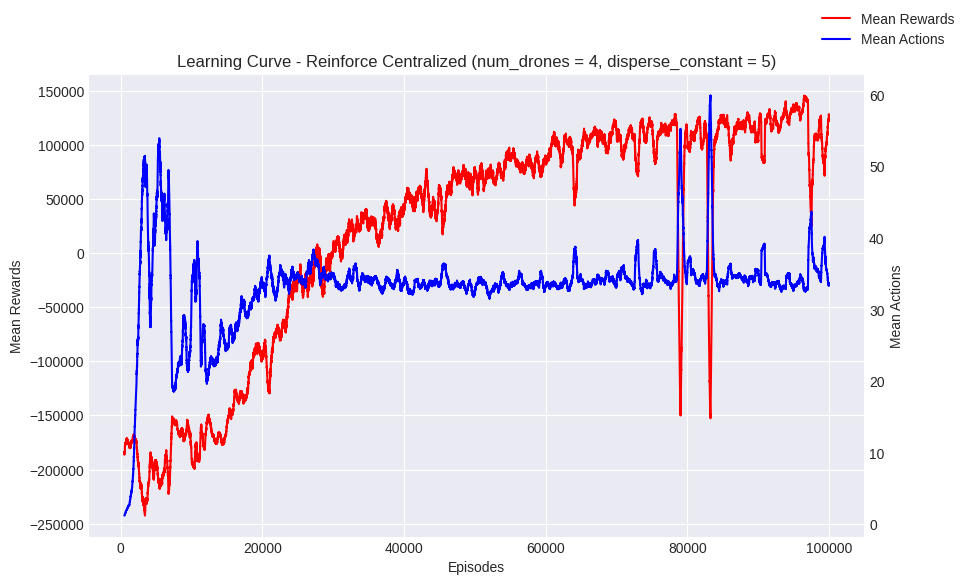

In [65]:
stat_rf = load_data(config_4, "reinforce")
plot_learning_curve(stat_rf, config_4, "Reinforce Centralized")

##  Comparing Algorithms - Collecting Data

In [12]:
def instantiate_env(config):
    env = DroneSwarmSearch(
        grid_size=config.grid_size,
        render_mode="ansi",
        render_grid=False,
        render_gradient=False,
        n_drones=config.n_drones,
        person_initial_position=config.person_initial_position,
        disperse_constant=config.disperse_constant,
        timestep_limit=config.timestep_limit,
    )
    return env

In [13]:
def collect_algorithms_data(config_number: int, algorithm):
    config = get_config(config_number)
    env = instantiate_env(config)
    print(f"Collecting data on {algorithm = } w/ {config = }")

    output_file = (
        f"{DATA_FOLDER}/results_{config}_{algorithm}.csv"
    )
    policy = get_model(algorithm, env, config)
    with open(output_file, "w", newline="") as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(
            [
                "reward",
                "steps",
                "found"
            ]
        )
        n_episodes = 10_000
        for i in range(n_episodes):
            print(f"In episode {i}/{n_episodes} - {config_number}", end="\r")
            reward, steps, found = play_one_episode(env, policy)

            writer.writerow(
                [
                    reward,
                    steps,
                    found
                ]
            )

    print(f"Data saved to {output_file}")

In [14]:
algorithms_to_compare = ["greedy"]
config_numbers = [2, 4]
for algorithm_name in algorithms_to_compare:
    for config_num in config_numbers:
        collect_algorithms_data(config_num, algorithm_name)

Data saved to data/results_20_4_1_greedy.csv
Data saved to data/results_20_4_5_greedy.csv


In [11]:
algorithms_to_compare = [""]
config_numbers = [2, 4]
for algorithm_name in algorithms_to_compare:
    for config_num in config_numbers:
        collect_algorithms_data(config_num, algorithm_name)


Loading neural network from models/nn_20_4_1_drone0_reinforce_il.pt
Loading neural network from models/nn_20_4_1_drone1_reinforce_il.pt
Loading neural network from models/nn_20_4_1_drone2_reinforce_il.pt
Loading neural network from models/nn_20_4_1_drone3_reinforce_il.pt
Data saved to data/results_20_4_1_reinforce_il.csv
Loading neural network from models/nn_20_4_5_drone0_reinforce_il.pt
Loading neural network from models/nn_20_4_5_drone1_reinforce_il.pt
Loading neural network from models/nn_20_4_5_drone2_reinforce_il.pt
Loading neural network from models/nn_20_4_5_drone3_reinforce_il.pt
Data saved to data/results_20_4_5_reinforce_il.csv
Loading model from models/nn_20_4_1_reinforce.pt


KeyboardInterrupt: 